In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras
import csv
import pandas as pd
import random
import numpy as np
from keras import regularizers
import re
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
import itertools
from string import ascii_lowercase
from functools import reduce
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [2]:
path='/content/drive/MyDrive/PP/dataset.csv'
df=pd.read_csv(path, encoding='latin')

In [3]:
df.head()

,sentiment,id,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.columns

Index(['sentiment', 'id', 'date', 'flag', 'user', 'tweet'], dtype='object')

In [5]:
df.isnull().sum()

sentiment    0
id           0
date         0
flag         0
user         0
tweet        0
dtype: int64

In [6]:
df.drop(['id', 'date', 'flag', 'user'], axis=1, inplace=True)

In [7]:
df.head()

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [8]:
df[df['sentiment']==4]

,sentiment,tweet
800000,4,I LOVE @Health4UandPets u guys r the best!!
800001,4,im meeting up with one of my besties tonight! ...
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,Being sick can be really cheap when it hurts t...
800004,4,@LovesBrooklyn2 he has that effect on everyone
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   tweet      1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [10]:
df['sentiment']=df['sentiment'].map({4:1,0:0})

In [11]:
df.head()

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [12]:
lens=df['tweet'].str.len()

Text(0, 0.5, 'Number of Tweets')

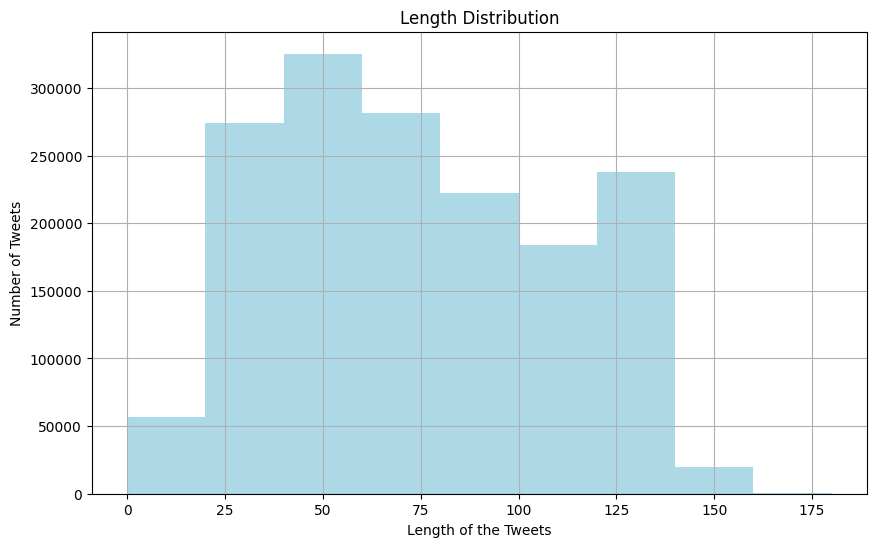

In [13]:
resize = np.arange(0, 200,20)
lens.hist(color='lightblue', figsize=(10, 6), bins=resize,width=20)
plt.title('Length Distribution')
plt.xlabel('Length of the Tweets')
plt.ylabel('Number of Tweets')

In [14]:
label=df['sentiment'].value_counts().index
val=df['sentiment'].value_counts().values

([<matplotlib.patches.Wedge at 0x7bb4f14a4520>,
 [Text(6.735557395310444e-17, 1.1, '0'),
  Text(-2.0206672185931328e-16, -1.1, '1')],
 [Text(3.6739403974420595e-17, 0.6, '50.00%'),
  Text(-1.1021821192326178e-16, -0.6, '50.00%')])

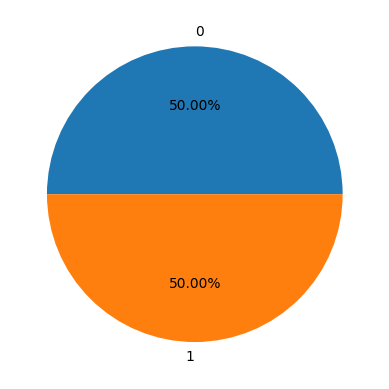

In [15]:
plt.pie(val, labels=label, autopct='%1.2f%%')

In [16]:
RE_PATTERNS = {

    " are not " : ["aren't"],
    " cannot " : ["can't"],
    " cannot have ": ["can't've"],
    " because ": ["cause"],
    " could have ": ["could've"],
    " could not ": ["couldn't"],
    " could not have ": ["couldn't've"],
    " did not ": ["didn't"],
    " does not ": ["doesn't"],
    " do not ": ["don't"],
    " had not ": ["hadn't"],
    " had not have ": ["hadn't've"],
    " has not ": ["hasn't"],
    " have not ": ["haven't"],
    " he would ": ["he'd"],
    " he would have ": ["he'd've"],
    " he will ": ["he'll"],
    " he is ": ["he's"],
    " how did ": ["how'd"],
    " how will ": ["how'll"],
    " how is ": ["how's"],
    " i would ": ["i'd"],
    " i will ": ["i'll"],
    " i am ": ["i'm"],
    " i have ": ["i've"],
    " is not ": ["isn't"],
    " it would ": ["it'd"],
    " it will ": ["it'll"],
    " it is ": ["it's"],
    " let us ": ["let's"],
    " madam ": ["ma'am"],
    " may not ": ["mayn't"],
    " might have ": ["might've"],
    " might not ": ["mightn't"],
    " must have ": ["must've"],
    " must not ": ["mustn't"],
    " need not ": ["needn't"],
    " ought not ": ["oughtn't"],
    " shall not ": ["shan't"],
    " shall not ": ["sha'n't"],
    " she would ": ["she'd"],
    " she will ": ["she'll"],
    " she is ": ["she's"],
    " should have ": ["should've"],
    " should not ": ["shouldn't"],
    " that would ": ["that'd"],
    " that is ": ["that's"],
    " there had ": ["there'd"],
    " there is ": ["there's"],
    " they would ": ["they'd"],
    " they will ": ["they'll"],
    " they are ": ["they're"],
    " they have ": ["they've"],
    " was not ":[ "wasn't"],
    " we would ": ["we'd"],
    " we will ": ["we'll"],
    " we are ": ["we're"],
    " we have ": ["we've"],
    " were not ": ["weren't"],
    " what will ": ["what'll"],
    " what are ": ["what're"],
    " what is ": ["what's"],
    " what have ":[ "what've"],
    " where did ": ["where'd"],
    " where is ": ["where's"],
    " who will ": ["who'll"],
    " who is ": ["who's"],
    " will not ": ["won't"],
    " would not ": ["wouldn't"],
    " you would ": ["you'd"],
    " you will ": ["you'll"],
    " you are ": ["you're"],
    ' american ':
        [
            'amerikan'
        ],

    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*',
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck','fuk', 'wtf','fucck','f cking'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$'
                                                           '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s'
        ],

    ' asshole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'ass hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h','beetch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' transgender':
        [
            'transgender','trans gender'
        ],

    ' gay ':
        [
            'gay'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k','diick '
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bullshit ':
        [
            'bullsh\*t', 'bull\$hit','bs'
        ],

    ' homosexual':
        [
            'homo sexual','homosex'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots', 'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t'
        ],

    ' shithole ':
        [
            'shythole','shit hole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumbass':
        [
            'dumb ass', 'dubass'
        ],

    ' asshead':
        [
            'butthead', 'ass head'
        ],

    ' sex ':
        [
            's3x', 'sexuality',
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' motherfucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker', 'mother fucker'
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
    ' though ': ['tho'],
    #' picture ': ['pic', 'pics'],
    ' soo ': ['so'],
    ' should ':['shoulda'],
    " aint ": ["am not"],
}

In [17]:
#Text Normalization

def clean_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):

  if is_lower:
    text=text.lower()


  if remove_patterns_text:
    for target, patterns in RE_PATTERNS.items():
      for pat in patterns:
        text=str(text).replace(pat, target)

  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text)


  text = re.sub('@[^\s]+','',text)
  text = re.sub(r'http\S+', '', text, flags=re.MULTILINE)
  text = str(text).replace("\n", " ")
  text = re.sub(r'[^\w\s]',' ',text)
  text = re.sub('[0-9]',"",text)
  text = re.sub(" +", " ", text)
  text = re.sub("([^\x00-\x7F])+"," ",text)

  return text

In [18]:
tweets = []
for line in df['tweet']:
    tweets.append(clean_text(line))

In [19]:
#Lemmatization

lemmatizer= WordNetLemmatizer()
def lemma(text, lemmatization=True):
  output=''
  if lemmatization:
    text=text.split(' ')
    for word in text:
      word1 = lemmatizer.lemmatize(word, pos = "n") #noun
      word2 = lemmatizer.lemmatize(word1, pos = "v") #verb
      word3 = lemmatizer.lemmatize(word2, pos = "a") #adjective
      word4 = lemmatizer.lemmatize(word3, pos = "r") #adverb
      output=output + " " + word4
  else:
    output=text

  return str(output.strip())

In [20]:
lema_tweets=[]
for line in tweets:
    lema_tweets.append(lemma(line))

In [21]:
#Stopwords Removal

stopword_list=[]
def iter_all_strings():
    for size in itertools.count(1):
        for s in itertools.product(ascii_lowercase, repeat=size):
            yield "".join(s)

dual_alpha_list=[]
for s in iter_all_strings():
    dual_alpha_list.append(s)
    if s == 'zz':
        break

dual_alpha_list.remove('i')
dual_alpha_list.remove('a')
dual_alpha_list.remove('am')
dual_alpha_list.remove('an')
dual_alpha_list.remove('as')
dual_alpha_list.remove('at')
dual_alpha_list.remove('be')
dual_alpha_list.remove('by')
dual_alpha_list.remove('do')
dual_alpha_list.remove('go')
dual_alpha_list.remove('he')
dual_alpha_list.remove('hi')
dual_alpha_list.remove('if')
dual_alpha_list.remove('is')
dual_alpha_list.remove('in')
dual_alpha_list.remove('me')
dual_alpha_list.remove('my')
dual_alpha_list.remove('no')
dual_alpha_list.remove('of')
dual_alpha_list.remove('on')
dual_alpha_list.remove('or')
dual_alpha_list.remove('ok')
dual_alpha_list.remove('so')
dual_alpha_list.remove('to')
dual_alpha_list.remove('up')
dual_alpha_list.remove('us')
dual_alpha_list.remove('we')


for letter in dual_alpha_list:
    stopword_list.append(letter)

In [22]:
print(len(stopword_list))
print(len(lema_tweets))

675
1600000


In [23]:
# Function that reads the entire dataset and adds words that are not already present in STOP_WORDS into a list of potential_stopwords.

def search_stopwords(data, search_stop=True):
  output=""
  if search_stop:
    data=data.split(" ")
    for word in data:
      if not word in stopword_list:
        output=output+" "+word
  else:
    output=data
  return str(output.strip())

# Calling the search_stopwords function, and saving words into a list (potential_stopwords).
#TRAIN
potential_stopwords = []
for line in lema_tweets:
    potential_stopwords.append(search_stopwords(line))
print(len(potential_stopwords))
print(potential_stopwords)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
# Combining all the sentences present in potential_stopwords into 4 different strings.
# Creation of each new string has a different function, this facilitates faster concatination of sentences.
def string_combine_a(stopword):
  final_a=""
  for item in range(400000):
    final_a=final_a+" "+stopword[item]
  return final_a

def string_combine_b(stopword):
  final_b=""
  for item in range(400001,800000):
    final_b=final_b+" "+stopword[item]
  return final_b

def string_combine_c(stopword):
  final_c=""
  for item in range(800001,1200000):
    final_c=final_c+" "+stopword[item]
  return final_c

def string_combine_d(stopword):
  final_d=""
  for item in range(1200001,1600000):
    final_d=final_d+" "+stopword[item]
  return final_d

total_string_potential_a=string_combine_a(potential_stopwords)

In [25]:
total_string_potential_b=string_combine_b(potential_stopwords)

In [26]:
total_string_potential_c=string_combine_c(potential_stopwords)

In [27]:
total_string_potential_d=string_combine_d(potential_stopwords)

In [28]:
# Counting the number of words in each of the 4 strings and saving it in a dictionary.
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    return counts

In [29]:
total_string_potential_a_dict=word_count(total_string_potential_a)

In [30]:
total_string_potential_b_dict=word_count(total_string_potential_b)

In [31]:
total_string_potential_c_dict=word_count(total_string_potential_c)

In [32]:
total_string_potential_d_dict=word_count(total_string_potential_d)

In [33]:
#Converting Dictionaries to Dataframe.
total_string_potential_a_df = pd.DataFrame(list(total_string_potential_a_dict.items()),columns = ['Word','Count'])

In [34]:
total_string_potential_b_df = pd.DataFrame(list(total_string_potential_b_dict.items()),columns = ['Word','Count'])

In [35]:
total_string_potential_c_df = pd.DataFrame(list(total_string_potential_c_dict.items()),columns = ['Word','Count'])

In [36]:
total_string_potential_d_df = pd.DataFrame(list(total_string_potential_d_dict.items()),columns = ['Word','Count'])

In [37]:
#Getting Dataframe output in descending order.
top50_potential_stopwords_a=total_string_potential_a_df.sort_values(by=['Count'],ascending=False).head(50)

In [38]:
top50_potential_stopwords_b=total_string_potential_b_df.sort_values(by=['Count'],ascending=False).head(50)

In [39]:
top50_potential_stopwords_c=total_string_potential_c_df.sort_values(by=['Count'],ascending=False).head(50)

In [40]:
top50_potential_stopwords_d=total_string_potential_d_df.sort_values(by=['Count'],ascending=False).head(50)

In [41]:
#Looking for common terms in all top 50 dataframes.
common_potential_stopwords=list(reduce(set.intersection,map(set,[top50_potential_stopwords_a.Word,top50_potential_stopwords_b.Word,top50_potential_stopwords_c.Word,top50_potential_stopwords_d.Word])))
print(common_potential_stopwords)

['just', 'now', 'on', 'up', 'not', 'of', 'this', 'at', 'have', 'that', 'my', 'but', 'what', 'be', 'all', 'get', 'you', 'will', 'a', 'to', 'we', 'know', 'i', 'too', 'good', 'go', 'soo', 'me', 'out', 'and', 'time', 'do', 'work', 'in', 'with', 'today', 'though', 'like', 'the', 'one', 'day', 'for']


In [42]:
#Retaining certain words and removing others from the above list.
#potential_stopwords_top500 = ['which', 'catch', 'since', 'full', 'pretty', 'exam', 'damn', 'minute', 'his', 'about', 'him', 'lol', 'send', 'then', 'rest', 'think', 'night', 'right', 'some', 'next', 'one', 'way', 'finish', 'yet', 'though', 'home', 'well', 'thing', 'more', 'eat', 'hair', 'totally', 'keep', 'already', 'can', 'be', 'awesome', 'sun', 'update', 'suck', 'meet', 'ok', 'any', 'soon', 'at', 'so', 'seem', 'feel', 'hey', 'month', 'girl', 'else', 'for', 'pick', 'stuff', 'link', 'saturday', 'com', 'idea', 'while', 'friday', 'concert', 'try', 'dinner', 'wonder', 'both', 'maybe', 'have', 'tweet', 'ago', 'gotta', 'money', 'find', 'gonna', 'dream', 'sister', 'watch', 'part', 'back', 'hear', 'these', 'least', 'world', 'early', 'worry', 'off', 'follower', 'through', 'haha', 'use', 'once', 'shoot', 'run', 'tho', 'dog', 'around', 'or', 'another', 'name', 'online', 'call', 'dad', 'excite', 'glad', 'leave', 'very', 'haven', 'tell', 'omg', 'should', 'know', 'do', 'didn', 'live', 'they', 'believe', 'enjoy', 'plurk', 'not', 'start', 'come', 'super', 'till', 'weather', 'okay', 'ever', 'the', 'bullshit', 'why', 'follow', 'by', 'eye', 'people', 'day', 'someone', 'something', 'problem', 'move', 'i', 'where', 'old', 'face', 'guy', 'sure', 'whole', 'outside', 'in', 'happy', 'pic', 'again', 'anyone', 'mean', 'last', 'read', 'hard', 'heart', 'go', 'own', 'stop', 'thank', 'trip', 'no', 'coffee', 'cause', 'brother', 'check', 'never', 'up', 'fuck', 'beach', 'god', 'everything', 'tomorrow', 'final', 'twitpic', 'he', 'boy', 'birthday', 'forget', 'but', 'luck', 'must', 'lunch', 'shop', 'post', 'them', 'cool', 'week', 'than', 'sunday', 'enough', 'also', 'sound', 'party', 'plan', 'nothing', 'probably', 'big', 'she', 'game', 'guess', 'only', 'rain', 'bite', 'two', 'myself', 'hi', 'reply', 'there', 'tonight', 'hot', 'talk', 'many', 'family', 'life', 'how', 'song', 'we', 'open', 'hopefully', 'finally', 'fan', 'nice', 'crazy', 'isn', 'yes', 'year', 'aww', 'time', 'that', 'wish', 'doe', 'really', 'before', 'play', 'summer', 'first', 'little', 'half', 'hour', 'see', 'saw', 'hate', 'new', 'book', 'if', 'real', 'lose', 'down', 'baby', 'work', 'kid', 'their', 'kinda', 'just', 'hit', 'room', 'hug', 'music', 'quot', 'want', 'yesterday', 'who', 'same', 'could', 'into', 'sit', 'wow', 'show', 'hop', 'man', 'all', 'actually', 'when', 'anything', 'long', 'give', 'don', 'best', 'busy', 'you', 'her', 'forward', 'shit', 'wait', 'study', 'tire', 'bring', 'thats', 'bed', 'turn', 'close', 'change', 'even', 'amaze', 'always', 'buy', 'cant', 'every', 'dude', 'school', 'to', 'dont', 'most', 'late', 'hand', 'lucky', 'yay', 'this', 'your', 'out', 'mom', 'here', 'love', 'may', 'those', 'doesn', 'win', 'bad', 'place', 'of', 'too', 'phone', 'miss', 'monday', 'over', 'picture', 'much', 'drink', 'stay', 'other', 'bore', 'happen', 'might', 'today', 'would', 'help', 'make', 'fun', 'news', 'will', 'soo', 'still', 'movie', 'far', 'take', 'until', 'mind', 'get', 'from', 'video', 'ready', 'wanna', 'ill', 'free', 'after', 'such', 'everyone', 'listen', 'put', 'break', 'http', 'hope', 'like', 'ask', 'hang', 'food', 'sorry', 'with', 'clean', 'a', 'away', 'need', 'job', 'and', 'spend', 'wake', 'an', 'say', 'mine', 'drive', 'me', 'weekend', 'wear', 'sleep', 'my', 'hell', 'yeah', 'almost', 'good', 'end', 'let', 'head', 'lot', 'great', 'twitter', 'class', 'car', 'please', 'remember', 'walk', 'few', 'because', 'on', 'what', 'look', 'our', 'write', 'now', 'house', 'morning', 'friend', 'amp']
potential_stopwords = ['age', 'which', 'since', 'his', 'about', 'him', 'then' , 'night', 'next', 'thing', 'at', 'so', 'hey', 'girl', 'for', 'com', 'tweet', 'sister', 'name', 'dad', 'should', 'they', 'the', 'where', 'brother', 'he', 'boy', 'must', 'them', 'week', 'than', 'she', 'hi', 'reply', 'there', 'man', 'her', 'thats', 'mom', 'here', 'those', 'will', 'http', 'and', 'twitter', 'amp']
#Adding above retrived words into the stopwords list.
for word in potential_stopwords:
    stopword_list.append(word)

In [43]:
def remove_stopwords(text, remove_stop=True):
  output = ""
  if remove_stop:
    text=text.split(" ")
    for word in text:
      if word not in stopword_list:
        output=output + " " + word
  else :
    output=text

  return str(output.strip())

In [45]:
#Removing Stopwords from Train Data
processed_tweets = []
for line in lema_tweets:
    processed_tweets.append(remove_stopwords(line))

In [46]:
processed_tweets[:10]

['that be a bummer you get david carr of third day to do',
 'be upset that cannot update facebook by texting might cry a a result school today soo blah',
 'i dive many time ball manage to save rest go out of bind',
 'my whole body feel itchy like on fire',
 'no be not behave all i be mad why be i be because i cannot see you all over',
 'not whole crew',
 'need a hug',
 'long time no see yes rain a bite only a bite lol i be fine thank how be you',
 'nope do not have',
 'que me muera']

In [47]:
df.head(10)

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [48]:
df.to_csv('/content/drive/MyDrive/PP/final_dataframe.csv')

In [49]:
df.head()

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
